Data

The file AB-Test.csv contains fictitious data from a Maps Search A/B Experiment where users are randomly assigned to either branch A or branch B with equal probability. The main metric of the experiment is whether users clicked on one of the search results.

Variables
* Branch: Indicates branches of an A/B experiment
* iOS: iOS version on device
* Country: country where user is located (US = United States; UK = United Kingdom; JP = Japan)
* Distance: distance between user and the closest returned result (in miles)
* Click.Through: whether user clicked on any of the returned results (0 = no; 1 = yes)

Questions
* Is branch B significantly better than branch A? Why?
* Any observations you want to comment on?

#### Import libraries needed

In [1]:
import numpy as np
import pandas as pd
import os

from scipy import stats
from statsmodels.stats.weightstats import ttest_ind as sm_ttest
from statsmodels.stats.weightstats import zconfint as sm_confint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pylab import rcParams
from pydotplus import graph_from_dot_data
from IPython.display import Image

%matplotlib inline
rcParams['figure.figsize'] = 10,8
sns.set_style('darkgrid')

In [2]:
np.set_printoptions(precision=2)
pd.set_option('precision',2)

#### Read data

In [3]:
data = pd.read_csv('../input/AB-Test.csv')

In [4]:
data.head()

,Branch,iOS,Country,Distance,Click.Through
0,A,10,US,15,0
1,A,10,UK,24,0
2,A,11,US,19,1
3,B,10,UK,6,0
4,A,11,US,20,0


In [5]:
cat_columns = ['Branch', 'iOS', 'Country', 'Click.Through']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
Branch           1000 non-null object
iOS              1000 non-null int64
Country          1000 non-null object
Distance         1000 non-null int64
Click.Through    1000 non-null int64
dtypes: int64(3), object(2)
memory usage: 39.1+ KB


In [7]:
data.loc[:,cat_columns] = data.loc[:, cat_columns].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
Branch           1000 non-null category
iOS              1000 non-null category
Country          1000 non-null category
Distance         1000 non-null int64
Click.Through    1000 non-null category
dtypes: category(4), int64(1)
memory usage: 12.2 KB


#### Have a deeper look into statistics of the data

In [8]:
print data.describe()
print '----------------------------------------'
for col in cat_columns:
    print data[col].value_counts()
    print '----------------------------------------'

       Distance
count   1000.00
mean      12.45
std        8.20
min        0.00
25%        5.00
50%       11.00
75%       20.00
max       32.00
----------------------------------------
A    501
B    499
Name: Branch, dtype: int64
----------------------------------------
11    582
10    418
Name: iOS, dtype: int64
----------------------------------------
US    745
UK    192
JP     63
Name: Country, dtype: int64
----------------------------------------
0    682
1    318
Name: Click.Through, dtype: int64
----------------------------------------


In [9]:
data['Click.Through'] = data['Click.Through'].astype('int')
data_conversion_country = (data.loc[data['Branch']=='A', 
                                    ['Country', 'Click.Through']]
                           .groupby('Country')
                           .mean()
                           .sort_values('Click.Through', ascending=False)
                          )
data_conversion_country.head()

,Click.Through
Country,
US,0.30
UK,0.29
JP,0.28


All countries have similar more or less similar conversion rates before test.

In [10]:
data_conversion_ios = (data.loc[data['Branch']=='A', 
                                    ['iOS', 'Click.Through']]
                           .groupby('iOS')
                           .mean()
                           .sort_values('Click.Through', ascending=False)
                          )
data_conversion_ios.head()

,Click.Through
iOS,
10,0.36
11,0.27


There is a higher conversion rate on iOS 10 before the test

In [11]:
print data.groupby(['Country', 'Branch']).size().unstack()
print '----------------------------------------'
print data.groupby(['Country', 'Branch']).size().unstack().pivot_table(columns='Country')

Branch     A    B
Country          
JP        32   31
UK        95   97
US       374  371
----------------------------------------
Country  JP  UK   US
Branch              
A        32  95  374
B        31  97  371


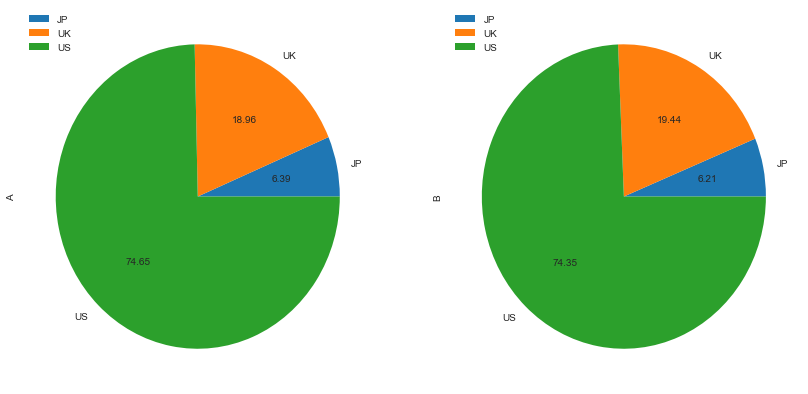

In [12]:
(data.groupby(['Country', 'Branch']).size()
     .unstack().plot.pie(subplots=True, 
                         figsize=[14,7], 
                         autopct='%.2f'));

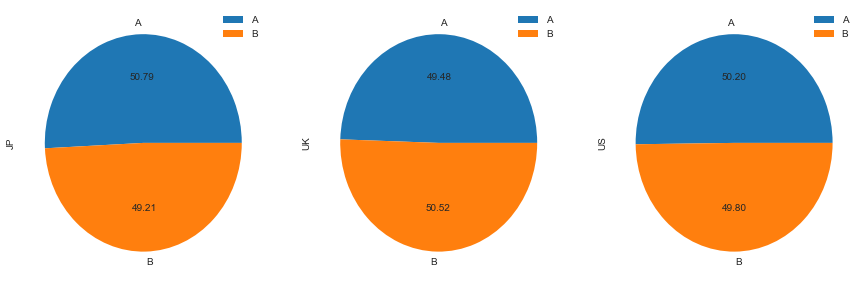

In [13]:
(data.groupby(['Country', 'Branch']).size()
     .unstack().pivot_table(columns='Country')
     .plot.pie(subplots=True, figsize=[15,5], 
               autopct='%.2f'));

#### "Naively" testing which branch is better when considering all the data using Welch two sample t-test:

In [14]:
tstat , pvalue, df  = sm_ttest(data[data.Branch=='A']['Click.Through'], 
                               data[data.Branch=='B']['Click.Through'])
print '----------------------------------------'
print 't = ', tstat , ', df = ', df, ', p-value = ', pvalue
print
print '95 percent confidence interval:'
print sm_confint(data[data.Branch=='A']['Click.Through'], 
                 data[data.Branch=='B']['Click.Through']
                )
print
print 'sample estimates:'
print 'mean of A = ', str(round(data[data.Branch=='A']['Click.Through'].mean()*100, 1)) + '%', ', mean of B = ', str(round(data[data.Branch=='B']['Click.Through'].mean()*100, 1)) + '%'
print '----------------------------------------'
# print (data[data.Branch=='B']['Click.Through'].mean()*100 - data[data.Branch=='A']['Click.Through'].mean()*100)/data[data.Branch=='A']['Click.Through'].mean()

----------------------------------------
t =  -1.4012405898295925 , df =  998.0 , p-value =  0.1614530223132519

95 percent confidence interval:
(-0.0990009789161296, 0.016456648738808838)

sample estimates:
mean of A =  29.7% , mean of B =  33.9%
----------------------------------------


The average conversion for users in group A is about 29.7% and the average for group B users is about 33.9%. This is about 14% increase in the conversion rate. This would normally be a significant increase in conversion. However the p-value of the t-test is large (>0.05) which indicates that the increase was not statistically significant. The most likely reason for such A/B results is the **not having enough data**. Anyhow we also need to check our results for any possible bias in our test/control sampling.

Firstly, let’s plot conversion rate within each country and for each iOS version, to see if the result stays the same.

#### Plot conversion rate vs country

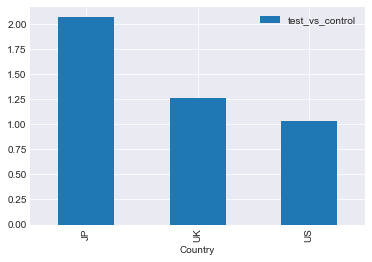

In [15]:
data_test_by_country = pd.DataFrame(data[data.Branch=='B']
                                .groupby('Country')
                                .mean()['Click.Through']
                                /data[data.Branch=='A']
                                .groupby('Country')
                                    .mean()['Click.Through'])
data_test_by_country.columns = ['test_vs_control']

# plt.plot(data_test_by_country.index, data_test_by_country.test_vs_control)
# plt.xlabel('Country');
# plt.ylabel('test_vs_control');
data_test_by_country.plot.bar()

#### Plot conversion rate vs iOS version

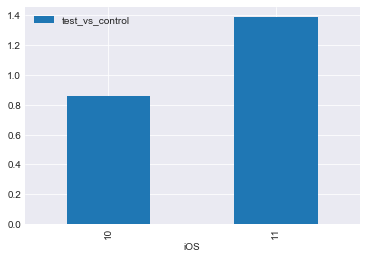

In [16]:
data_test_by_ios = pd.DataFrame(data[data.Branch=='B']
                                .groupby('iOS')
                                .mean()['Click.Through']
                                /data[data.Branch=='A']
                                .groupby('iOS')
                                    .mean()['Click.Through'])
data_test_by_ios.columns = ['test_vs_control']

# plt.plot(data_test_by_ios.index, data_test_by_ios.test_vs_control);
# plt.xlabel('iOS version');
# plt.ylabel('test_vs_control');
data_test_by_ios.plot.bar()

From the plot, we notice a couple of things:

1. The effect of the test hasn't been the same across all contries. The test seems to be working much better for Japanese users, then UK, and finally had the least improvment for US users. More specifically, the success for Japanese users looks like too good to be true. This indicates higher possibility of bias in our sampling.

2. The test has been more effective for users with iOS 11. Although initially iOS 10 users had higher conversion rate, but the experiment was more effective for iOS 11 users.

Next, we will look at bias. There might be some segment of users that are more likely be picked as a test (i.e. 'B') or as a control ('A'). This segment may then have a significantly above/below conversion rate which would affect the overall results.

In an ideal world, the distribution of people in test and control for each segment should be the same. This may be checked by building a decision tree classifier where the features are user dimensions and the outcome variable is whether the user was in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. This should not happen if the randomization were correctly done, and the tree should not split at all (or at least not be able to separate the two classes well).

Let’s check this:

In [17]:
X = data.drop(labels=['Click.Through', 'Branch'],axis=1)
y = data['Branch']

In [18]:
X.head()

,iOS,Country,Distance
0,10,US,15
1,10,UK,24
2,11,US,19
3,10,UK,6
4,11,US,20


In [19]:
X = pd.get_dummies(X)
X.head()

,Distance,iOS_10,iOS_11,Country_JP,Country_UK,Country_US
0,15,1,0,0,0,1
1,24,1,0,0,1,0
2,19,0,1,0,0,1
3,6,1,0,0,1,0
4,20,0,1,0,0,1


In [20]:
le = LabelEncoder()
le.fit(y)
y = pd.DataFrame({'Branch':le.transform(y)})
y.head()

,Branch
0,0
1,0
2,0
3,1
4,0


In [21]:
clf = DecisionTreeClassifier(max_depth=2,
                             min_samples_leaf = len(data)//100
                            )
clf.fit(X,y)
print(clf.score(X, y))

0.987


This is a really high classication score which shows that the classiffier successfully predict if a user will end of in branch 'A' or branch 'B'. This is a strong indication of high bias in our sampling.

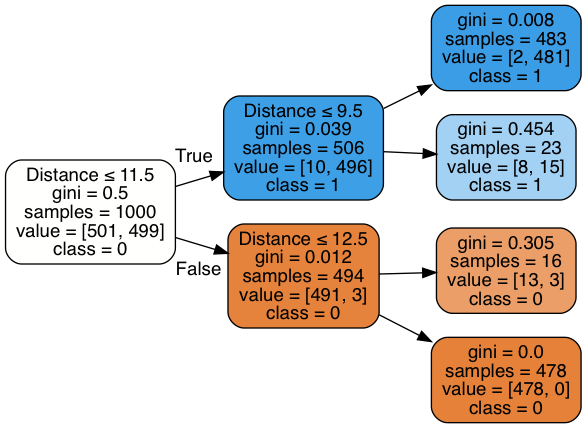

In [22]:
tree = export_graphviz(clf, feature_names=X.columns, 
                       class_names=['0', '1'], filled=True, rounded=True,
                       out_file=None, special_characters=True, rotate=True)

graph = graph_from_dot_data(tree)
Image(graph.create_png())

Looks very interesting! It looks like there was no randomization done at all! All the users with their distance to the closest returned result less than 11.5 miles were assigned to group A and all other users were assigned to group B. Althought there are the same number of samples in each group, but this is a completely biased sampling and the experiment would not provide any meaningful conclusion.

If there was somekind of randomization at least within the on of the tree splits, we could have continued our analysis for that subgroup.

Another insight that we can get from the data is that the users in Japan were closer to their desitication compare to users in UK and USA. This is in agreement with the higher population density in Japan.

We could also continue this analysis and check for what aer the majority of iOS version in each country.